In [ ]:
# Load necessary libraries
library(brms)
library(tidyverse)
library(ggplot2)
library(dplyr)

Loading required package: Rcpp

Loading 'brms' package (version 2.22.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar


Warning message:
“package ‘ggplot2’ was built under R version 4.5.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
This is bayesplot version 1.12.0

- Online documentation and vignettes at mc-stan.org/bayesp

In [15]:
# Set working directory to notebook location (standard R practice)
# Using here package - install with: install.packages("here")
if (!requireNamespace("here", quietly = TRUE)) {
  install.packages("here")
}
library(here)
setwd(here("final_paper_analysis"))


The downloaded binary packages are in
	/var/folders/0g/m5_p35yx2rn2p8kgk1rv_7tm0000gn/T//Rtmpxv5waQ/downloaded_packages


here() starts at /Users/aschharwood/evaluating_organic_waste_bans



# Data

In [20]:
df <- read.csv("data.csv")
df$sector_name <- as.factor(df$sector_name)
glimpse(df)



Rows: 64
Columns: 8
$ state                          <chr> "california", "california", "california…
$ year                           <int> 1999, 2003, 2008, 2008, 2014, 2018, 201…
$ sector_name                    <fct> sector_combined, sector_combined, secto…
$ log_food_tons                  <dbl> 15.53551, 15.58270, 14.92541, 14.92500,…
$ adjusted_quant_score_linear    <dbl> 0.000000, 0.000000, 0.000000, 0.000000,…
$ inflation_adjusted_tipping_fee <dbl> 47.03000, 47.03100, 53.05004, 53.05004,…
$ pce_scaled                     <dbl> 15.0934096, 17.0308663, 18.8109959, 18.…
$ centered_search                <dbl> 4.2018229, 4.2018229, 4.2018229, 4.2018…


In [18]:
glimpse(df)

Rows: 64
Columns: 8
$ state                          <chr> "california", "california", "california…
$ year                           <int> 1999, 2003, 2008, 2008, 2014, 2018, 201…
$ sector_name                    <chr> "sector_combined", "sector_combined", "…
$ log_food_tons                  <dbl> 15.53551, 15.58270, 14.92541, 14.92500,…
$ adjusted_quant_score_linear    <dbl> 0.000000, 0.000000, 0.000000, 0.000000,…
$ inflation_adjusted_tipping_fee <dbl> 47.03000, 47.03100, 53.05004, 53.05004,…
$ pce_scaled                     <dbl> 15.0934096, 17.0308663, 18.8109959, 18.…
$ centered_search                <dbl> 4.2018229, 4.2018229, 4.2018229, 4.2018…


# Models

### Log-Log with Strong Prior

In [21]:
fit_log_strong_prior <- readRDS('model_experiments/strong_prior_model.rds')

#### Results

In [22]:
summary(fit_log_strong_prior)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: log(food_tons_clean) ~ adjusted_quant_score_linear + log(pce_scaled) + centered_search + inflation_adjusted_tipping_fee + sector_name + (1 | state) 
   Data: df (Number of observations: 64) 
  Draws: 4 chains, each with iter = 4000; warmup = 2000; thin = 1;
         total post-warmup draws = 8000

Multilevel Hyperparameters:
~state (Number of levels: 22) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.20      0.06     0.09     0.33 1.00     2341     2556

Regression Coefficients:
                               Estimate Est.Error l-95% CI u-95% CI Rhat
Intercept                         12.33      0.35    11.68    13.02 1.00
adjusted_quant_score_linear       -0.02      0.01    -0.03    -0.01 1.00
logpce_scaled                      1.05      0.07     0.91     1.17 1.00
centered_search                   -0.01      0.00    -0.02     0.00 1.00
inflation_adjusted_tipping_fee   

#### PP_Check

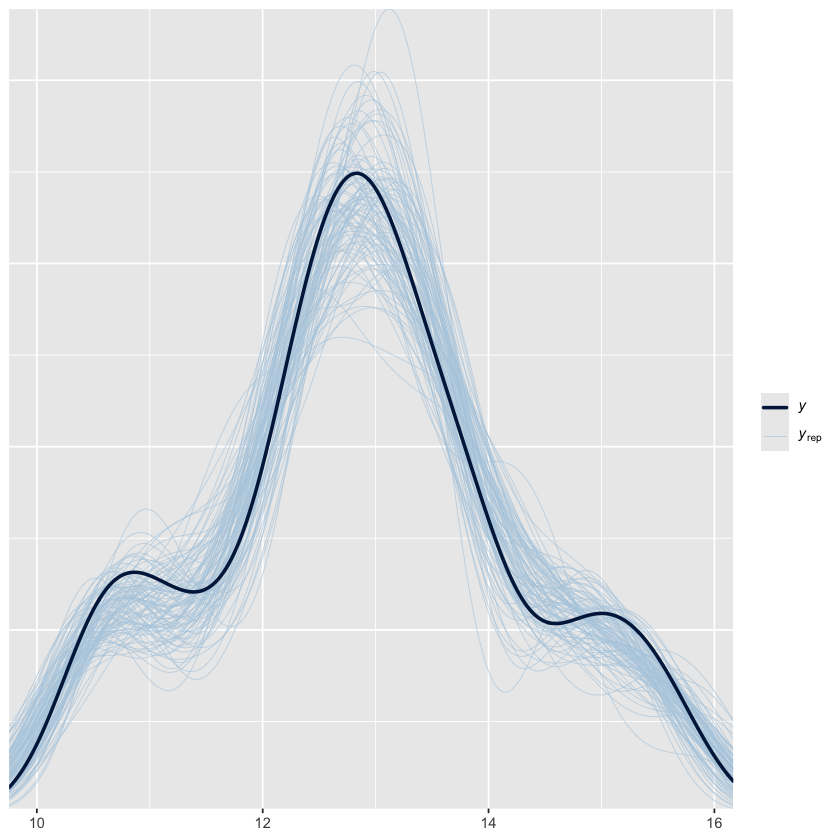

In [5]:
pp_check(fit_log_strong_prior, ndraws = 100)

In [6]:
loo_strong_prior <- loo::loo(fit_log_strong_prior, moment_match = TRUE)

In [7]:
loo_strong_prior


Computed from 8000 by 64 log-likelihood matrix.

         Estimate   SE
elpd_loo     -8.5  6.7
p_loo        16.0  2.9
looic        17.1 13.4
------
MCSE of elpd_loo is 0.1.
MCSE and ESS estimates assume MCMC draws (r_eff in [0.4, 1.5]).

All Pareto k estimates are good (k < 0.7).
See help('pareto-k-diagnostic') for details.

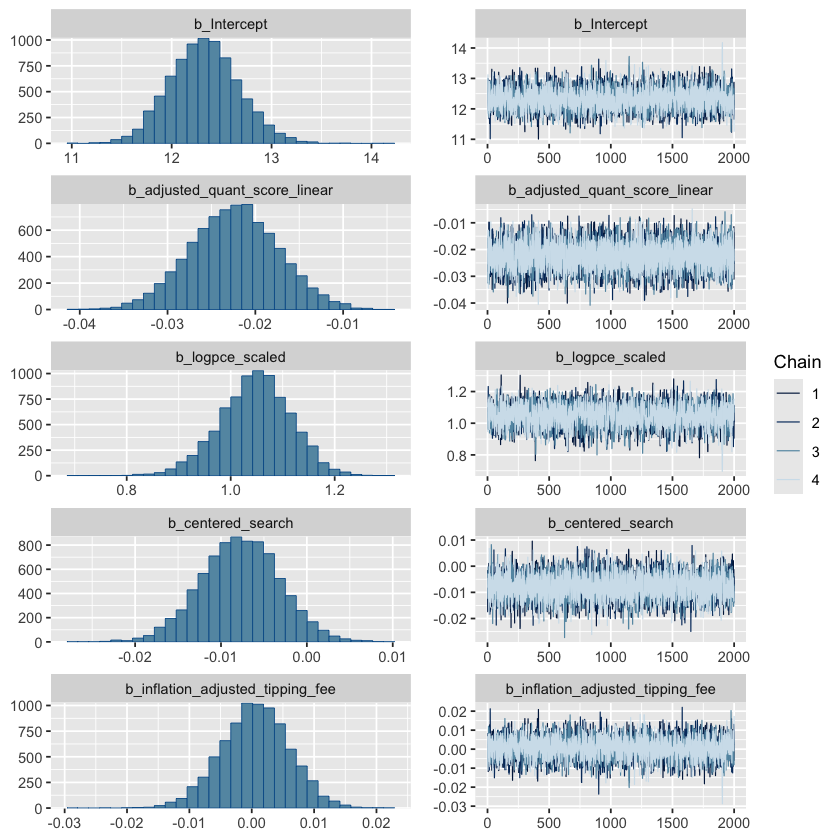

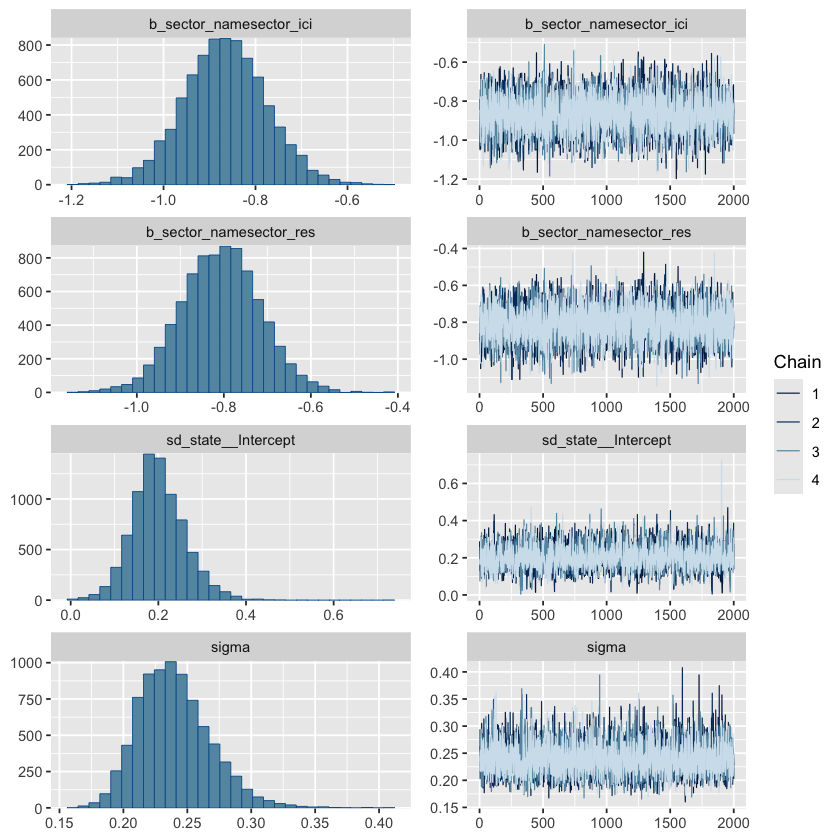

In [10]:
plot(fit_log_strong_prior)

## Log-Log Uninformative Prior

In [11]:
log_log_model <- readRDS("model_experiments/uninformative_prior_model.rds")


### Results

In [12]:
summary(log_log_model)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: log(food_tons_clean) ~ adjusted_quant_score_linear + log(pce_scaled) + centered_search + inflation_adjusted_tipping_fee + sector_name + (1 | state) 
   Data: df (Number of observations: 64) 
  Draws: 4 chains, each with iter = 4000; warmup = 2000; thin = 1;
         total post-warmup draws = 8000

Multilevel Hyperparameters:
~state (Number of levels: 22) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.19      0.06     0.08     0.33 1.00     1988     2158

Regression Coefficients:
                               Estimate Est.Error l-95% CI u-95% CI Rhat
Intercept                         12.37      0.33    11.72    13.05 1.00
adjusted_quant_score_linear       -0.02      0.01    -0.03     0.00 1.00
logpce_scaled                      1.05      0.07     0.91     1.17 1.00
centered_search                   -0.01      0.00    -0.02     0.00 1.00
inflation_adjusted_tipping_fee   

### Diagnostics

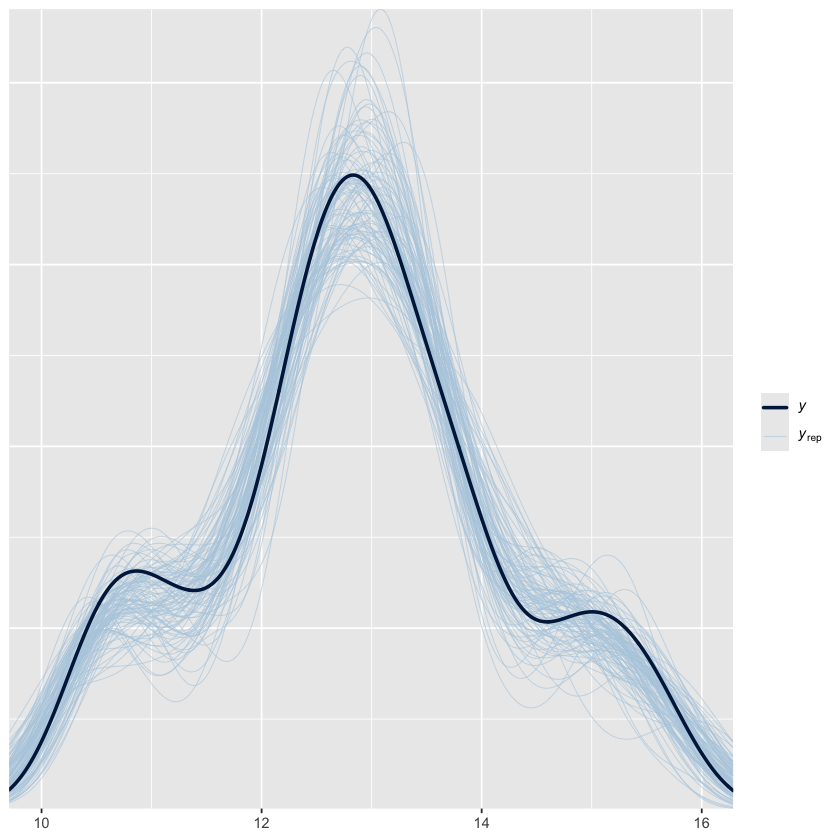

In [44]:
pp_check(log_log_model, ndraws = 100)

In [45]:
loo_log_uninformative <- loo::loo(log_log_model, moment_match = TRUE)

In [46]:
loo_log_uninformative


Computed from 8000 by 64 log-likelihood matrix.

         Estimate   SE
elpd_loo     -9.4  6.6
p_loo        16.5  2.9
looic        18.8 13.1
------
MCSE of elpd_loo is 0.1.
MCSE and ESS estimates assume MCMC draws (r_eff in [0.4, 1.5]).

All Pareto k estimates are good (k < 0.7).
See help('pareto-k-diagnostic') for details.